In [ ]:
import os
from skimage.io import imread
import matplotlib.pyplot as plt


### Color detection of ants
This project aims at deteting the color of ants in images

![alt text](imagename.png "Title")

In [39]:
# Path to the folder containing images
folder_path = '/Volumes/T7 Shield/AntProject/original'

# List all files in the folder and sort them
all_files = sorted(os.listdir(folder_path))

# Filter only the image files (e.g., with extensions .jpg, .png)
image_files = [f for f in all_files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]


In [ ]:
#Number of images in folder
print(len(image_files))

38578


In [ ]:
#Looking at 100 images
first_100_images = image_files[0:100]

# Reading in the 100 images
images = []
for image_file in first_100_images:
    image_path = os.path.join(folder_path, image_file)
    
    if image_file.startswith('._'):
        continue
    try:
        img = imread(image_path)
        images.append(img)
    except Exception as e:
        print(f"Error reading {image_file}: {e}")

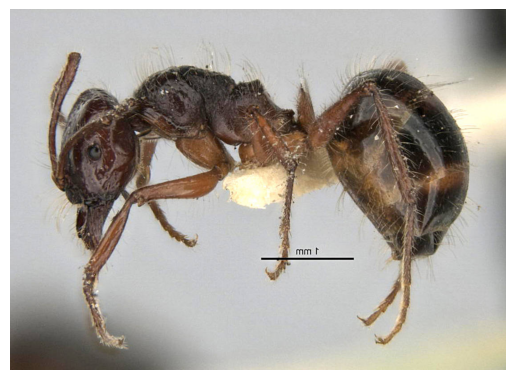

In [37]:
plt.imshow(images[46])
plt.axis('off')  # Optional: turn off the axis for a cleaner look
plt.show()